In [1]:
from our_library.our_reusable_methods import *

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# **Tematyka projektu**
Stworzenie modelu regresji do przewidywania ilości spożywanego przez młodzież alkoholu zależnie od czynników środowiskowych. <br>
https://data.world/data-society/student-alcohol-consumption <br>
Oryginalny zbiór zawiera dane z podziałem na szkoły i 2 tabeli posiadają dane nt. ocen z matematyki oraz języka. Połączyłem obie tabelki w jedną i usunąłem niepotrzebne kolumny. Zmienne opisywane to spożycie w tygodniu oraz w weekendy. Połączę obie zmienne w jedną we wspólny współczynnik patologicznego spożycia, gdzie picie w tygodniu będzie liczone wyżej.

# **Przygotowanie danych**

In [2]:
# wczytanie zbioru i usunięcie niepotrzebnych nam kolumn
d1 = pd.read_csv("student-mat.csv")
d2 = pd.read_csv("student-por.csv")
# łączę obie tabelki w jedną
dataset = pd.concat([d1,d2], ignore_index=True)
# zakładam, że picie w tygodniu dwukrotnie mocniej wskazuje na problem alkoholowy
dataset['alc'] = 2 * dataset.Dalc + dataset.Walc
# usuwam zbędne kolumny
columns_to_drop = ["school","G1","G2","G3","paid","Dalc","Walc"]
dataset = dataset.drop(columns=columns_to_drop)
# usunięcie rekordów z brakami
dataset = dataset.dropna()
# prosta binaryzacja atrybutów tam gdzie to możliwe
dataset.sex = dataset.sex.apply(lambda x:0 if x=="F" else 1)
dataset.address = dataset.address.apply(lambda x:0 if x=="R" else 1)
dataset.famsize = dataset.famsize.apply(lambda x:0 if x=="LE3" else 1)
dataset.Pstatus = dataset.Pstatus.apply(lambda x:0 if x=="T" else 1)
# zamiast pisać ręcznie dla każdej jak powyżej
yes_no_columns = ['schoolsup','famsup','activities','nursery','higher','internet','romantic']
for c in yes_no_columns:
    dataset[c] = dataset[c].apply(lambda x:0 if x=="yes" else 1)
# binaryzacja techniką one-hot-encode atrybytów kategorycznych
features_to_encode = ['Mjob','Fjob','reason','guardian']
encoder = OneHotEncoder()
results = encoder.fit_transform(dataset.loc[:,features_to_encode])
# zamiana starych atr. kat. na nowe one-hot-y
dataset_without_categoricals = dataset.drop(columns=features_to_encode).reset_index().drop(columns=["index"])
encoded_categoricals = pd.DataFrame(results.toarray(), columns=encoder.get_feature_names(features_to_encode)).reset_index().drop(columns=["index"])
dataset = pd.concat([dataset_without_categoricals, encoded_categoricals], axis=1)
# zamiana typów danych na int64
dataset = dataset.convert_dtypes()

In [3]:
dataset.describe().iloc[1:,:]

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
mean,0.433908,16.726054,0.727011,0.706897,0.115900,2.603448,2.387931,1.522989,1.970307,0.264368,...,0.559387,0.279693,0.062261,0.411877,0.247126,0.103448,0.237548,0.232759,0.697318,0.069923
std,0.495850,1.239975,0.445708,0.455404,0.320259,1.124907,1.099938,0.731727,0.834353,0.656142,...,0.496699,0.449064,0.241744,0.492409,0.431548,0.304689,0.425785,0.422792,0.459639,0.255140
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.000000,1.000000,1.000000,0.000000,3.000000,2.000000,1.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,18.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


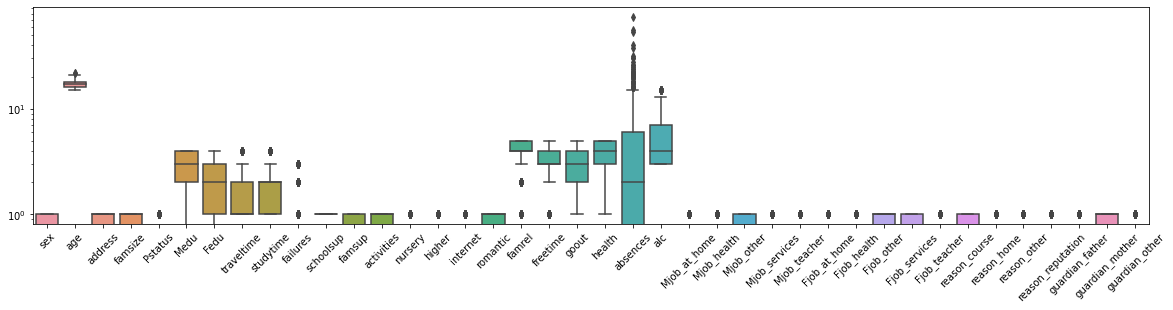

In [4]:
plt.figure(figsize=(20,4))
ax = sns.boxplot(data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_yscale('log')

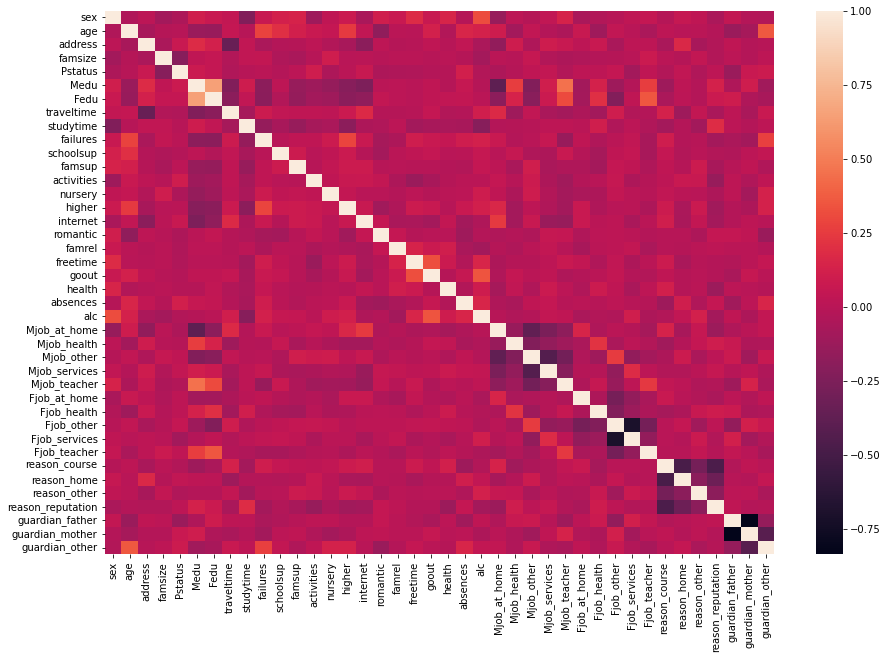

In [5]:
plt.figure(figsize=(15,10))
sns.heatmap(data=dataset.corr());

In [6]:
# skalowanie minmax, nie wpływa na nasze atr. binarne, ale wyrównuje wpływ z pozostałymi atrybutami
scaler = MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns = dataset.columns)
# podział wyczyszczonego zbioru na części, wszystko robimy na treningowym (włącznie z walidacją), 
# a testowy dopiero na sam koniec dla już wybranego modelu
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['alc']), dataset['alc'], test_size=0.2, random_state=1)

# **Szukanie Modelu**

# Regresja Grzbietowa

0/99 10/99 20/99 30/99 40/99 50/99 60/99 70/99 80/99 90/99 

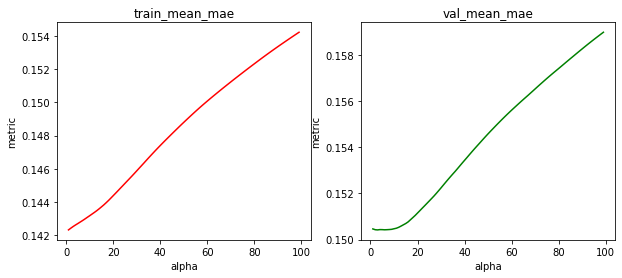

In [7]:
alphas = np.arange(1,100,1)
models = [Ridge(alpha=a, random_state=1) for a in alphas]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,10,scoring='neg_mean_absolute_error')
fig,axes = plot_train_vs_validation_scores(train_mean_mae,val_mean_mae,alphas,["train_mean_mae","val_mean_mae"],"alpha")

# Regresja Lasso

0/99 10/99 20/99 30/99 40/99 50/99 60/99 70/99 80/99 90/99 

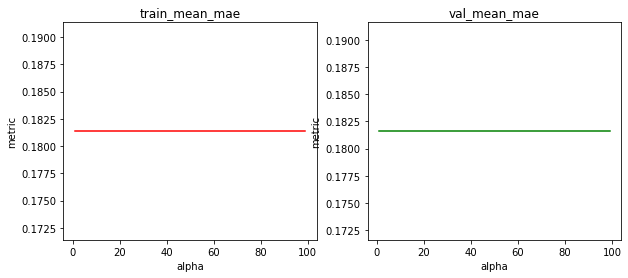

In [8]:
alphas = np.arange(1,100,1)
models = [Lasso(alpha=a, random_state=1) for a in alphas]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,10,scoring='neg_mean_absolute_error')
fig,axes = plot_train_vs_validation_scores(train_mean_mae,val_mean_mae,alphas,["train_mean_mae","val_mean_mae"],"alpha")

In [45]:
best_model = Lasso(alpha=1, random_state=1)
best_model.fit(X_train,y_train)
ypred = best_model.predict(X_test)
mean_absolute_error(y_test, ypred)

0.1849692958580447

# Regresja Liniowa (Wieloraka)

In [12]:
models = [LinearRegression()]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,10,scoring='neg_mean_absolute_error',silent=True)
print(f"train_mean_mae = {train_mean_mae[0]}\nval_mean_mae = {val_mean_mae[0]}")

train_mean_mae = 0.14268630707335328
val_mean_mae = 0.1511110591317365


In [46]:
best_model = LinearRegression()
best_model.fit(X_train,y_train)
ypred = best_model.predict(X_test)
mean_absolute_error(y_test, ypred)

0.16262647029505584

# Maszyna Wektorów Nośnych Dla Regresji

# Jądro Liniowe

0/100 10/100 20/100 30/100 40/100 50/100 60/100 70/100 80/100 90/100 

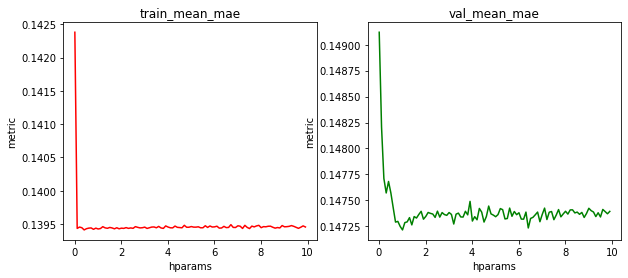

In [24]:
hparams = np.arange(0.01,10,0.1)
models = [SVR(kernel='linear',C=hp) for hp in hparams]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,10,scoring='neg_mean_absolute_error')
fig,axes = plot_train_vs_validation_scores(train_mean_mae,val_mean_mae,hparams,["train_mean_mae","val_mean_mae"],"C")

In [39]:
best_model = SVR(kernel='linear', C=1)
best_model.fit(X_train,y_train)
ypred = best_model.predict(X_test)
mean_absolute_error(y_test, ypred)

0.1557967791940543

# Jądro Wielomianowe

0/30 1/30 2/30 3/30 4/30 5/30 6/30 7/30 8/30 9/30 10/30 11/30 12/30 13/30 14/30 15/30 16/30 17/30 18/30 19/30 20/30 21/30 22/30 23/30 24/30 25/30 26/30 27/30 28/30 29/30 0/99 10/99 20/99 30/99 40/99 50/99 60/99 70/99 80/99 90/99 0/100 10/100 20/100 30/100 40/100 50/100 60/100 70/100 80/100 90/100 

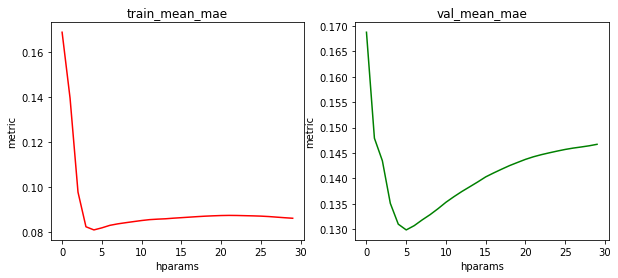

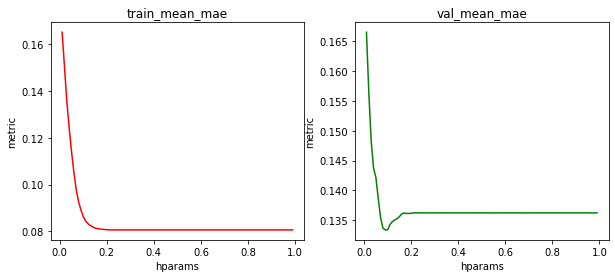

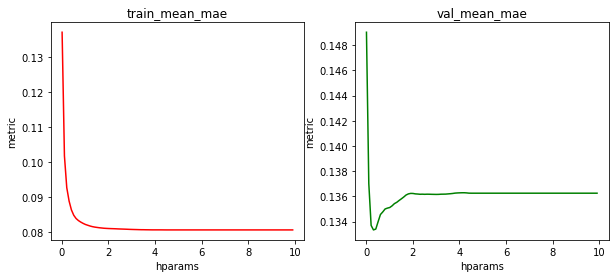

In [25]:
hparams = np.arange(0,30,1)
models = [SVR(kernel='poly',degree=hp) for hp in hparams]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,1,scoring='neg_mean_absolute_error')
fig,axes = plot_train_vs_validation_scores(train_mean_mae,val_mean_mae,hparams,["train_mean_mae","val_mean_mae"],"degree")
hparams = np.arange(0.01,1,0.01)
models = [SVR(kernel='poly',gamma=hp) for hp in hparams]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,10,scoring='neg_mean_absolute_error')
fig,axes = plot_train_vs_validation_scores(train_mean_mae,val_mean_mae,hparams,["train_mean_mae","val_mean_mae"],"gamma")
hparams = np.arange(0.01,10,0.1)
models = [SVR(kernel='poly',C=hp) for hp in hparams]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,10,scoring='neg_mean_absolute_error')
fig,axes = plot_train_vs_validation_scores(train_mean_mae,val_mean_mae,hparams,["train_mean_mae","val_mean_mae"],"C")

In [38]:
best_model = SVR(kernel='poly',degree=5, gamma=0.1, C=0.31)
best_model.fit(X_train,y_train)
ypred = best_model.predict(X_test)
mean_absolute_error(y_test, ypred)

0.14409232291771618

# Jądro Gaussa (RBF)

0/99 10/99 20/99 30/99 40/99 50/99 60/99 70/99 80/99 90/99 0/100 10/100 20/100 30/100 40/100 50/100 60/100 70/100 80/100 90/100 

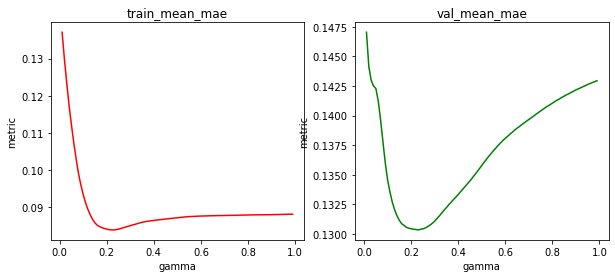

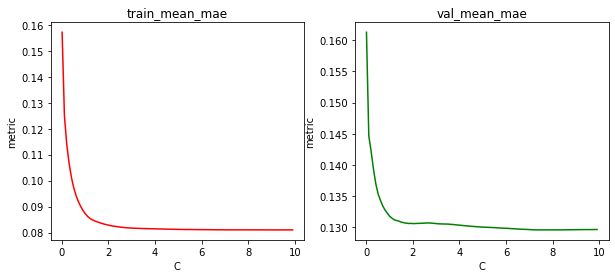

In [40]:
hparams = np.arange(0.01,1,0.01)
models = [SVR(kernel='rbf',gamma=hp) for hp in hparams]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,10,scoring='neg_mean_absolute_error')
fig,axes = plot_train_vs_validation_scores(train_mean_mae,val_mean_mae,hparams,["train_mean_mae","val_mean_mae"],"gamma")
hparams = np.arange(0.01,10,0.1)
models = [SVR(kernel='rbf',C=hp) for hp in hparams]
train_mean_mae,val_mean_mae = cross_validate_models(models,X_train,y_train,10,scoring='neg_mean_absolute_error')
fig,axes = plot_train_vs_validation_scores(train_mean_mae,val_mean_mae,hparams,["train_mean_mae","val_mean_mae"],"C")

In [50]:
best_model = SVR(kernel='rbf', gamma=0.21, C=10)
best_model.fit(X_train,y_train)
ypred = best_model.predict(X_test)
mean_absolute_error(y_test, ypred)

0.14124217044650048

W oryginalnych danych alkoholizm był określany w skali 1-5 (very low, low, avg, high, very high). Po przeskalowaniu na zakres 0-1, jednemu punktowi w skali odpowiada 0.2. W większości modeli błąd był mniejszy niż 0.2 i bliski 0.14. Oznacza to, że nasz model nie myli się bardziej niż o jeden stopień w skali czyli np. kogoś kto pije mało zaklasyfikuje w najgorszym razie jako pijącego bardzo mało lub średnio. Największe błędy model osiąga dla osób, których warunki środowiskowe są bardzo trudne ale osoby te mają silny charakter i nie przesadzają z alkoholem pomimo trudnego życia (to bardzo optymistyczne :)).